# Moment-Curvature Validation


In [1]:
%matplotlib widget
from bmcs_cross_section.api import ReinfLayer, BarLayer, EC2, MKappa, TShape
import bmcs_utils.api as bu
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import numpy as np

In [2]:
bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

def plot_mk_ver(mc, ver_data, test_name, title=None, ax=None, color_i=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    mc.plot_mk(ax, dashed=True, color=plot_colors[color_i])
    k = ver_data[0]
    m = ver_data[1]
    ax.plot(k, m, c=plot_colors[color_i], label= 'Exp. (' + test_name + ')')
    if title is not None:
        ax.set_title(title)
    ax.legend()
    if 'fig' in locals():
        return fig, ax

def make_mc(form='rectangular', B=200, H=200, 
            material_r1='steel', E_r1=200000, high_kappa = 0.00005,
            f_cm=40, matrix = 'EC2', eps_cr = None, eps_cy=None, eps_cu=None, eps_tu=None, mu=None, E_cc=None, E_ct=None,
            f_ctm=None,
            z_r1=10,
            A_r1=100,
            f_t_r1=None,
            f_sy_r1=500,
            f_st_r1=None,
            eps_ud_r1=0.025,
            material_r2=None, 
            z_r2=None, 
            A_r2=None,
            E_r2=None,
            f_t_r2=None,
            f_sy_r2=None,
            f_st_r2=None,
            eps_ud_r2=0.025,
            n_kappa=200, n_m = 200, slider=None):
    
    mc = MKappa(low_kappa=0, 
                high_kappa=high_kappa,
                n_m=n_m,
                n_kappa=n_kappa)
    
    mc.cs_design.matrix = matrix
    if slider is not None:
        mc.kappa_slider = slider
    
    if form=='rectangular':
        mc.cross_section_shape_.B = B
        mc.cross_section_shape_.H = H
    
    if matrix == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
        eps_cy = eps_cy,
        eps_cu = eps_cu,
    )
    else:
        mc.cs_design.matrix_.f_cm=f_cm
        
    if eps_tu is not None:
        mc.cs_design.matrix_.eps_tu = eps_tu
    if eps_cr is not None:
        mc.cs_design.matrix_.eps_cr = eps_cr
    if mu is not None:
        mc.cs_design.matrix_.mu = mu
    if E_cc is not None:
        mc.cs_design.matrix_.E_cc = E_cc
    if E_ct is not None:
        mc.cs_design.matrix_.E_ct = E_ct
    
    bl1 = ReinfLayer(name='layer1', z=z_r1, A=A_r1, matmod=material_r1)
    if material_r1 == 'carbon':
        bl1.matmod_.trait_set(E=E_r1,f_t=f_t_r1)
    if material_r1 == 'steel':
        bl1.matmod_.trait_set(E_s=E_r1, f_sy=f_sy_r1, eps_ud = eps_ud_r1, f_st=1.05*f_sy_r1 if f_st_r1 is None else f_st_r1)
    mc.cross_section_layout.add_layer(bl1)
    
    if material_r2 is not None:
        bl2 = ReinfLayer(name='layer2', z=z_r2, A=A_r2, matmod=material_r2)
        if material_r2 == 'carbon':
            bl2.matmod_.trait_set(E=E_r2,f_t=f_t_r2)
        if material_r2 == 'steel':
            bl2.matmod_.trait_set(E_s=E_r2, f_sy=f_sy_r2, eps_ud = eps_ud_r2, f_st=1.05*f_sy_r2 if f_st_r2 is None else f_st_r2)
        mc.cross_section_layout.add_layer(bl2)
    
    return mc

def get_data(element1, xlsx_file, k, m, element2=False, k_faktor=False):
    if element2 == False:
        excel_file = join(element1, xlsx_file)
    else: excel_file = join(element1, element2, xlsx_file)
    data = pd.read_excel(excel_file, engine='openpyxl')
    if(k_faktor==False):
        k_faktor = 1
    k = data[k]*k_faktor
    m = data[m]
    ver_data = [k, m]
    
    return ver_data

## Model validation with experimental results

### Rectangluar cross sections

### Gribniak et al. (2012) (FRC with Steel reinforcement), https://doi.org/10.1016/j.engstruct.2012.04.032
![ver_rec_2.jpg](attachment:ver_rec_2.jpg)

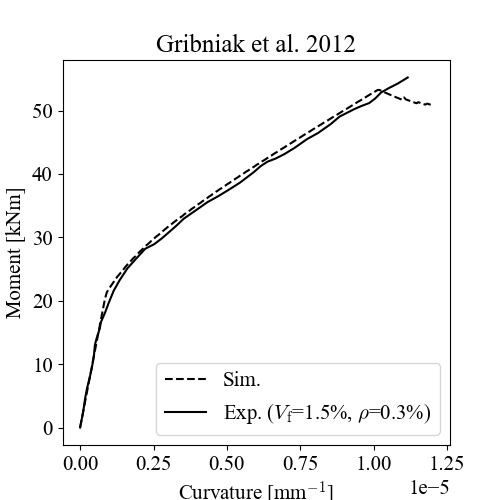

In [4]:
# Beam S3-1-F15
ver_data = get_data(element1='verification_data',
                    xlsx_file='fig_6.xlsx',
                    k='S3_1_F15_Curvature',
                    m='S3_1_F15_Moment',
                    element2='Gribniak2012')
mc = make_mc(form='rectangular', high_kappa=12e-6, B=279, H=300,
             mu=0.61, eps_cr=0.000132, eps_tu=0.0023,
             f_cm=52.2,
#              eps_cy=0.00175, eps_cu=0.0035, 
             material_r1='steel', z_r1=(300-272), A_r1=235, E_r1=202800, f_sy_r1=560,
             material_r2='steel', z_r2=(300-26), A_r2=56, E_r2=202800, f_sy_r2=560)
fig, ax = plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=1.5%, $\rho$=0.3%', title='Gribniak et al. 2012', color_i=0)
fig
mc.interact()

In [5]:
# Beam S3_1_F05
ver_data = get_data(element1='./verification_data/Gribniak2012/', xlsx_file='fig_6.xlsx', k='S3_1_F05_Curvature', m='S3_1_F05_Moment')
mc = make_mc(form='rectangular', high_kappa=14e-6, B=278, H=302,
             mu=0.42, eps_cr=0.000132, eps_tu=0.0025,
             f_cm=55.6,
#              eps_cy=0.00175, eps_cu=0.0035, 
             material_r1='steel', z_r1=(302-278), A_r1=235, E_r1=202800, f_sy_r1=560,
             material_r2='steel', z_r2=(302-29), A_r2=56, E_r2=202800, f_sy_r2=560)
plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=0.5%, $\rho$=0.3%', ax=ax, color_i=1)
fig
mc.interact()

In [ ]:
# fig.savefig('MK_Gribniak_S3-1-F15_S3-1-F05.pdf')

### Yang et al. (2010) (FRC with steel reinforcement), http://dx.doi.org/10.1016/j.engstruct.2010.07.017
![yang_2010.jpg](attachment:yang_2010.jpg)

In [ ]:
0.000384 * 46418

In [ ]:
# R12-1,2 (rho = 0.6%)
ver_data = get_data(element1='./verification_data/Yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R12_2_Curvature', m='beam_R12_2_Moment')
mc = make_mc(
            form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=46418, E_ct=46418,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 190.9/46418,
            eps_cu = EC2.get_eps_cu3(190.9-8),
            material_r1='steel', z_r1=35, A_r1=253.4, E_r1=200000, f_sy_r1=600,
            )
fig, ax = plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=2%, $\rho$=0.6%', title='Yang et al. 2010', color_i=0)
fig
mc.interact()

In [ ]:
# R13-2 (rho = 0.9%)
ver_data = get_data(element1='./verification_data/Yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R13_2_Curvature', m='beam_R13_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=46680, E_ct=46680,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 192.2/46680,
            eps_cu = EC2.get_eps_cu3(192.2-8),
            material_r1='steel', z_r1=35, A_r1=380.1, E_r1=200000, f_sy_r1=600,
            )
plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=2%, $\rho$=0.9%', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
fig.savefig('MK_Yang_R12-1_R13-2.pdf')

###  Almusallam1997 (Steel, GFRP) https://journals.sagepub.com/doi/pdf/10.1177/002199839703100701

In [ ]:
# Group 1 (Steel):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_1_Curvature', m='Group_1_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000065, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*7**2, E_r1 = 200000, z_r1=50, f_sy_r1=553,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
# fig, ax = plot_mk_ver(mc, ver_data, r'Group 1 - Steel', title='Almusallam 1997', color_i=0)
mc.interact()

In [ ]:
# Group 2 (GFRP):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_2_Curvature', m='Group_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000066, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(19/2)**2, E_r1 = 35630, z_r1=210-158, f_t_r1=700,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
plot_mk_ver(mc, ver_data, r'Group 2 - GFRP', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# Group 3 (GFRP):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_3_Curvature', m='Group_3_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00007, B=200, H=260,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(12.7/2)**2, E_r1 = 43370, z_r1=260-211, f_t_r1=886,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
plot_mk_ver(mc, ver_data, r'Group 3 - GFRP', ax=ax, color_i=2)
# fig
mc.interact()

In [ ]:
# fig.savefig('MK_Almusallam1997.pdf')

### Bazan2020 (Steel reinf. strengthened with CFRP sheet )

In [ ]:
# SC-01 (Steel + CFRP):
ver_data = get_data(element1='./verification_data/Bazan2020', xlsx_file='fig_7.xlsx', k='SC-01_Curvature', m='SC-01_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000037, B=200, H=400,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=30,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*(16/2)**2, E_r1 = 200000, z_r1=400-342, f_sy_r1=500, # f_sy=420 acco. to paper
             A_r2 = 2*np.pi*(8/2)**2,  E_r2 = 200000, z_r2=342, f_sy_r2=500
             
            )
l1 = ReinfLayer(name='carbon', z=0, A=200, matmod='carbon')
l1.matmod_.trait_set(E=95800,f_t=985)
mc.cross_section_layout.add_layer(l1)

fig, ax = plot_mk_ver(mc, ver_data, 'SC-01 - [Steel + CFRP]', title='Bazan et al. 2020', color_i=0)
fig
# mc.interact()

In [ ]:
# SC-02 (Steel + CFRP):
ver_data = get_data(element1='./verification_data/Bazan2020', xlsx_file='fig_7.xlsx', k='SC-02_Curvature', m='SC-02_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000037, B=200, H=400,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=30,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(16/2)**2 + 1*np.pi*(12/2)**2, E_r1 = 200000, z_r1=400-329, f_sy_r1=500, # f_sy=420 acco. to paper
             A_r2 = 2*np.pi*(8/2)**2,  E_r2 = 200000, z_r2=329, f_sy_r2=500
            )
l1 = ReinfLayer(name='carbon', z=0, A=200, matmod='carbon')
l1.matmod_.trait_set(E=95800,f_t=985)
mc.cross_section_layout.add_layer(l1)

plot_mk_ver(mc, ver_data, 'SC-02 - [Steel + CFRP]', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# fig.savefig('MK_Bazan2020.pdf')